In [1]:
import torch
print(torch.__version__)

2.6.0+cu124


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
#Creating a neural network for image multiclass classification on mnist dataset

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [4]:
# 2️⃣ MNIST dataset (images are 28x28 = 784 pixels)
transform = transforms.Compose([
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize to mean & std of MNIST
])

In [5]:
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
# 3️) Feedforward Neural Network
class FeedForwardNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten image (batch_size, 784)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)  # No softmax here (CrossEntropyLoss applies it internally)
        return x

In [7]:
model = FeedForwardNN().to(device)

In [8]:
# 4️ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# 5️ Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/5], Loss: 0.2588
Epoch [2/5], Loss: 0.1060
Epoch [3/5], Loss: 0.0740
Epoch [4/5], Loss: 0.0589
Epoch [5/5], Loss: 0.0495


In [10]:
# 6️ Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.37%


In [11]:
import matplotlib.pyplot as plt
import numpy as np

## **EVALUATION ON TEST SET**

In [12]:
model.eval()
correct = 0
total = 0
test_loss_total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss_total += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_test_loss = test_loss_total / len(test_loader)
final_test_acc = 100 * correct / total

print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Final Test Loss: 0.0882
Final Test Accuracy: 97.37%


In [13]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize (if needed)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Predict
images_device = images.to(device)
outputs = model(images_device)
_, preds = torch.max(outputs, 1)

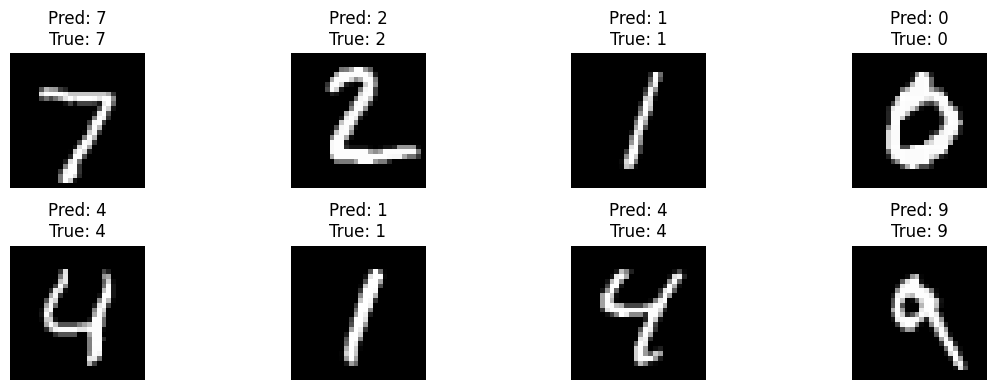

In [14]:
# Plot first 8 test images with predictions
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()